# Forecasting with machine learning

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

2023-02-26 10:59:47.228679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

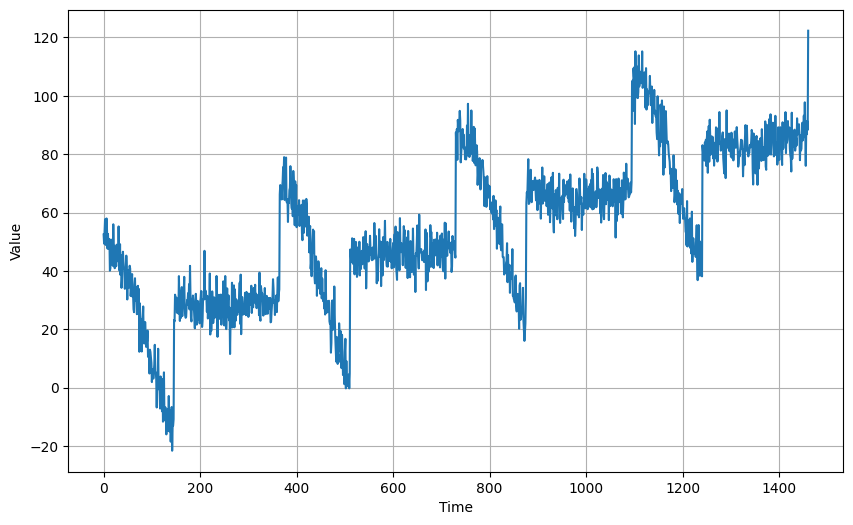

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Train and plot the mechanized model

In [6]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism



## Create and Compile the model

In [7]:

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-26 11:01:36.550575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:


mechanized_model = MechanizedSequential([
  keras.layers.Dense(1, input_shape=[window_size])
])


lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)


mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)




## Choose mechanism and fit the model

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

mechanized_model.choose_mech(None)

empirical_history = mechanized_model.fit(train_set, epochs = 10, callbacks=[lr_schedule])

Epoch 1/10
31/31 [==============================] - 1s 11ms/step - loss: 31.5770 - mae: 32.0756 - lr: 1.0000e-06
Epoch 2/10
31/31 [==============================] - 1s 14ms/step - loss: 18.4942 - mae: 18.9893 - lr: 1.0798e-06
Epoch 3/10
31/31 [==============================] - 1s 14ms/step - loss: 11.2514 - mae: 11.7384 - lr: 1.1659e-06
Epoch 4/10
31/31 [==============================] - 0s 11ms/step - loss: 10.8640 - mae: 11.3529 - lr: 1.2589e-06
Epoch 5/10
31/31 [==============================] - 0s 12ms/step - loss: 10.7823 - mae: 11.2684 - lr: 1.3594e-06
Epoch 6/10
31/31 [==============================] - 0s 11ms/step - loss: 10.7155 - mae: 11.2023 - lr: 1.4678e-06
Epoch 7/10
31/31 [==============================] - 0s 11ms/step - loss: 10.6371 - mae: 11.1243 - lr: 1.5849e-06
Epoch 8/10
31/31 [==============================] - 0s 13ms/step - loss: 10.5640 - mae: 11.0524 - lr: 1.7113e-06
Epoch 9/10
31/31 [==============================] - 0s 11ms/step - loss: 10.4727 - mae: 10.9592 

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.05)


gaussian_history = mechanized_model.fit(train_set, epochs = 10, callbacks=[lr_schedule])

Epoch 1/10
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      1/Unknown - 0s 137ms/step - loss: 10.4152 - mae: 10.8959In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      5/Unknown - 0s 15ms/step - loss: 9.4195 - mae: 9.9063   In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      9/Unknown - 0s 15ms/step - loss: 9.8417 - mae: 10.3308In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussi

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


threshold_history = mechanized_model.fit(train_set, epochs = 10, callbacks=[lr_schedule])

Epoch 1/10
In Threshold out Mechanism
16.129164
      1/Unknown - 0s 241ms/step - loss: 10.3654 - mae: 8.0230In Threshold out Mechanism
3.5088234
In Threshold out Mechanism
4.04261
      3/Unknown - 0s 35ms/step - loss: 8.9726 - mae: 7.0102  In Threshold out Mechanism
0.9369011
In Threshold out Mechanism
7.7845383
      5/Unknown - 0s 33ms/step - loss: 9.8720 - mae: 9.1044In Threshold out Mechanism
6.020672
In Threshold out Mechanism
8.813869
      7/Unknown - 0s 32ms/step - loss: 9.7710 - mae: 9.3035In Threshold out Mechanism
10.040348
      8/Unknown - 0s 35ms/step - loss: 9.9013 - mae: 9.4726In Threshold out Mechanism
5.6763306
      9/Unknown - 1s 42ms/step - loss: 9.8987 - mae: 9.7931In Threshold out Mechanism
5.102356
In Threshold out Mechanism
7.4026794
     11/Unknown - 1s 42ms/step - loss: 9.6668 - mae: 9.9658In Threshold out Mechanism
8.346174
     12/Unknown - 1s 43ms/step - loss: 9.8485 - mae: 10.2740In Threshold out Mechanism
9.408432
     13/Unknown - 1s 46ms/step - loss:

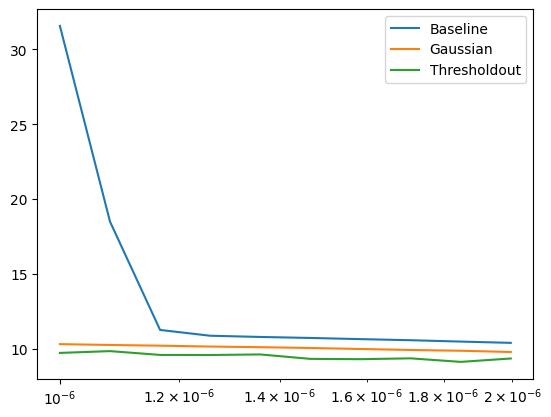

In [12]:
plt.semilogx(empirical_history.history["lr"], empirical_history.history["loss"], label = "Baseline")
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"], label = "Gaussian")
plt.semilogx(threshold_history.history["lr"], threshold_history.history["loss"], label = "Thresholdout")
plt.legend()
plt.show()

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

In [15]:
mechanized_model = MechanizedSequential([
  keras.layers.Dense(1, input_shape=[window_size])
])




keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

mechanized_model.choose_mech(None)
mechanized_model.set_gaussian_para(0, 0.1)

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

mechanized_model.fit(train_set, epochs = 50,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/50
31/31 [==============================] - 1s 21ms/step - loss: 701.4833 - mae: 701.9832 - val_loss: 2386.0920 - val_mae: 2386.5916
Epoch 2/50
31/31 [==============================] - 1s 15ms/step - loss: 630.6161 - mae: 631.1162 - val_loss: 1502.1630 - val_mae: 1502.6627
Epoch 3/50
31/31 [==============================] - 1s 15ms/step - loss: 337.5266 - mae: 338.0266 - val_loss: 1860.5651 - val_mae: 1861.0654
Epoch 4/50
31/31 [==============================] - 1s 15ms/step - loss: 635.1713 - mae: 635.6699 - val_loss: 1159.7050 - val_mae: 1160.2050
Epoch 5/50
31/31 [==============================] - 1s 15ms/step - loss: 392.7076 - mae: 393.2073 - val_loss: 857.3907 - val_mae: 857.8907
Epoch 6/50
31/31 [==============================] - 1s 15ms/step - loss: 364.9604 - mae: 365.4604 - val_loss: 2187.2244 - val_mae: 2187.7239
Epoch 7/50
31/31 [==============================] - 1s 16ms/step - loss: 913.0497 - mae: 913.5494 - val_loss: 2022.9365 - val_mae: 2023.4368
Epoch 8/50
31/3

In [16]:
lin_forecast = model_forecast(mechanized_model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 4ms/step


In [17]:
mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.1)

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

mechanized_model.fit(train_set, epochs = 50,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/50
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      1/Unknown - 0s 110ms/step - loss: 872.1821 - mae: 872.6821In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      5/Unknown - 0s 13ms/step - loss: 815.8089 - mae: 816.3089 In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
     10/Unknown - 0s 13ms/step - loss: 746.6951 - mae: 747.1951In Gaussian Mechanism
Create

In [18]:
gaussian_lin_forecast = model_forecast(mechanized_model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 3ms/step


In [19]:
mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
early_stopping = keras.callbacks.EarlyStopping(patience=10)

mechanized_model.fit(train_set, epochs = 50,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/50
In Threshold out Mechanism
217.73181
      1/Unknown - 0s 134ms/step - loss: 1475.0515 - mae: 1416.6831In Threshold out Mechanism
149.8847
In Threshold out Mechanism
14.999908
      3/Unknown - 0s 31ms/step - loss: 829.8555 - mae: 798.3448   In Threshold out Mechanism
120.843445
In Threshold out Mechanism
15.897491
      5/Unknown - 0s 32ms/step - loss: 681.2762 - mae: 656.1517In Threshold out Mechanism
20.706345
In Threshold out Mechanism
10.813263
      7/Unknown - 0s 31ms/step - loss: 511.4335 - mae: 495.2870In Threshold out Mechanism
269.88245
In Threshold out Mechanism
87.150696
      9/Unknown - 0s 32ms/step - loss: 527.6591 - mae: 499.5808In Threshold out Mechanism
17.801056
In Threshold out Mechanism
120.721375
     11/Unknown - 0s 31ms/step - loss: 504.2544 - mae: 481.1186In Threshold out Mechanism
18.850098
In Threshold out Mechanism
101.8714
     13/Unknown - 1s 31ms/step - loss: 552.2236 - mae: 532.0715In Threshold out Mechanism
5.7648315
In Threshold out Mechani

In [20]:
threshold_lin_forecast = model_forecast(mechanized_model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 3ms/step


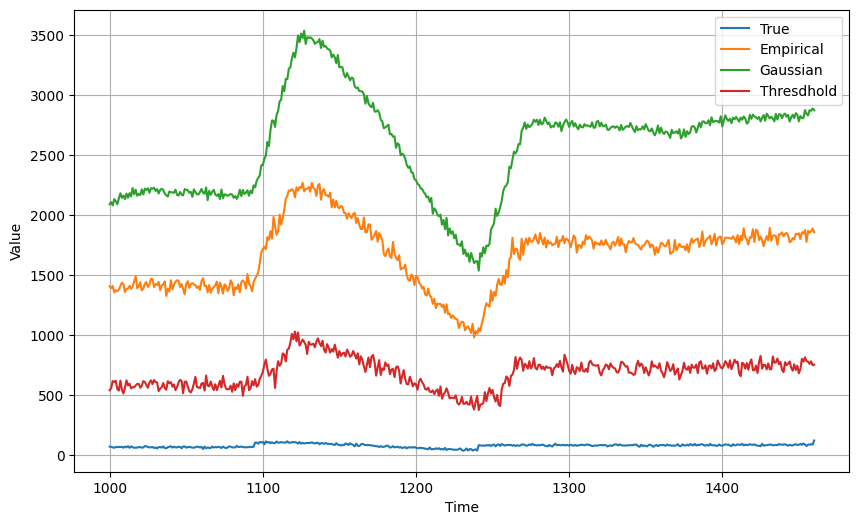

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")

plot_series(time_valid, lin_forecast, label = "Empirical")

plot_series(time_valid, gaussian_lin_forecast, label = "Gaussian")
plot_series(time_valid, threshold_lin_forecast, label = "Thresdhold")
plt.legend()


In [22]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

1586.2622

In [23]:
keras.metrics.mean_absolute_error(x_valid, gaussian_lin_forecast).numpy()

2495.9753

### Dense Model Forecasting

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

Epoch 1/100
31/31 [==============================] - 1s 16ms/step - loss: 109.8821 - mae: 110.3809 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 107.4042 - mae: 107.9034 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 104.4150 - mae: 104.9143 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 101.1088 - mae: 101.6081 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 97.4673 - mae: 97.9667 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 93.4393 - mae: 93.9388 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 89.0255 - mae: 89.5251 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 84.1743 - mae: 84.6740 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 78.8908 - mae:

# Dense mechanized model forecasting

In [32]:
mechanized_model = MechanizedSequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])


lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)


In [33]:
mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.1)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
empirical_history = mechanized_model.fit(train_set, epochs = 10, callbacks=[lr_schedule])


Epoch 1/10
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      1/Unknown - 0s 170ms/step - loss: 11.6121 - mae: 12.1121In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      4/Unknown - 0s 25ms/step - loss: 10.2655 - mae: 10.7544 In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      7/Unknown - 0s 25ms/step - loss: 10.1822 - mae: 10.6721In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
     10/Unknown - 0s 23ms/step - l

In [34]:
mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.1)
mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
gaussian_history = mechanized_model.fit(train_set, epochs = 10, callbacks=[lr_schedule])

Epoch 1/10
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      1/Unknown - 0s 229ms/step - loss: 5.9953 - mae: 6.4805In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      3/Unknown - 0s 29ms/step - loss: 7.7104 - mae: 8.1961 In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      6/Unknown - 0s 25ms/step - loss: 9.1519 - mae: 9.6353In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      9/Unknown - 0s 22ms/step - loss: 8.3824 - mae: 8.8695In Gaussian Mechanism
Create Gaussian noise when accessing

In [35]:
mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)

mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
threshold_history = mechanized_model.fit(train_set, epochs = 10, callbacks=[lr_schedule])

Epoch 1/10
In Threshold out Mechanism
6.560032
      1/Unknown - 0s 128ms/step - loss: 11.9548 - mae: 11.8205In Threshold out Mechanism
8.067772
In Threshold out Mechanism
1.8410988
      3/Unknown - 0s 40ms/step - loss: 9.0994 - mae: 8.8162   In Threshold out Mechanism
8.701302
In Threshold out Mechanism
15.734196
      5/Unknown - 0s 38ms/step - loss: 8.3885 - mae: 8.5043In Threshold out Mechanism
15.7355995
In Threshold out Mechanism
3.4120445
      7/Unknown - 0s 36ms/step - loss: 8.7462 - mae: 9.6581In Threshold out Mechanism
2.6012459
In Threshold out Mechanism
10.081253
      9/Unknown - 0s 36ms/step - loss: 8.6708 - mae: 8.9636In Threshold out Mechanism
1.6044579
In Threshold out Mechanism
2.0354424
     11/Unknown - 0s 36ms/step - loss: 8.3940 - mae: 8.6860In Threshold out Mechanism
5.0181465
In Threshold out Mechanism
3.2965813
     13/Unknown - 1s 36ms/step - loss: 8.2370 - mae: 8.6526In Threshold out Mechanism
8.801235
In Threshold out Mechanism
9.120026
     15/Unknown - 1

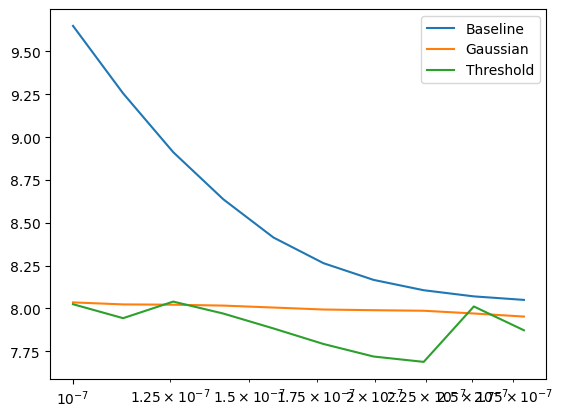

In [36]:
plt.semilogx(empirical_history.history["lr"], empirical_history.history["loss"], label = "Baseline")
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"], label = "Gaussian")
plt.semilogx(threshold_history.history["lr"], threshold_history.history["loss"], label = "Threshold")

plt.legend()


# Mechanized dense forecast

In [47]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

In [48]:
mechanized_model = MechanizedSequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
early_stopping = keras.callbacks.EarlyStopping(patience=10)


In [49]:
mechanized_model.choose_mech(None)

mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
mechanized_model.fit(train_set, epochs= 50,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/50
31/31 [==============================] - 1s 21ms/step - loss: 64.8776 - mae: 65.3764 - val_loss: 76.8680 - val_mae: 77.3679
Epoch 2/50
31/31 [==============================] - 1s 23ms/step - loss: 38.4450 - mae: 38.9427 - val_loss: 65.8905 - val_mae: 66.3905
Epoch 3/50
31/31 [==============================] - 1s 20ms/step - loss: 18.9028 - mae: 19.3965 - val_loss: 35.9324 - val_mae: 36.4306
Epoch 4/50
31/31 [==============================] - 1s 20ms/step - loss: 16.1656 - mae: 16.6605 - val_loss: 34.6224 - val_mae: 35.1220
Epoch 5/50
31/31 [==============================] - 1s 20ms/step - loss: 16.4644 - mae: 16.9567 - val_loss: 35.2297 - val_mae: 35.7282
Epoch 6/50
31/31 [==============================] - 1s 20ms/step - loss: 15.2441 - mae: 15.7383 - val_loss: 32.3430 - val_mae: 32.8422
Epoch 7/50
31/31 [==============================] - 1s 20ms/step - loss: 15.2090 - mae: 15.7023 - val_loss: 33.9261 - val_mae: 34.4253
Epoch 8/50
31/31 [==============================] - 1s 

In [50]:
dense_forecast = model_forecast(
    mechanized_model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 3ms/step


In [51]:
mechanized_model.choose_mech(Mechanism.GAUSSIAN)
mechanized_model.set_gaussian_para(0, 0.1)

mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
mechanized_model.fit(train_set, epochs= 50,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/50
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      1/Unknown - 0s 164ms/step - loss: 17.2563 - mae: 17.7343In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      4/Unknown - 0s 18ms/step - loss: 16.0925 - mae: 16.5829 In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      6/Unknown - 0s 22ms/step - loss: 15.2835 - mae: 15.7742In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
In Gaussian Mechanism
Create Gaussian noise when accessing the training data
      9/Unknown - 0s 20ms/step - loss: 15.7268 - mae: 16.2194In Gaussian Mechanism
Create Gaussian noise when a

In [52]:
gaussian_dense_forecast = model_forecast(
    mechanized_model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 3ms/step


In [54]:
mechanized_model.choose_mech(Mechanism.THRESHOLD)
mechanized_model.set_mechanism_para(sigma = 0.1, hold_frac = 0.4, threshold = 0.5)


mechanized_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"],
              run_eagerly = True)
mechanized_model.fit(train_set, epochs= 50,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/50
In Threshold out Mechanism
0.2896843
      1/Unknown - 0s 126ms/step - loss: 16.5042 - mae: 12.9717In Threshold out Mechanism
0.2897339
In Threshold out Mechanism
3.4847298
      3/Unknown - 0s 35ms/step - loss: 15.8498 - mae: 13.9298 In Threshold out Mechanism
1.4612083
In Threshold out Mechanism
2.283661
      5/Unknown - 0s 36ms/step - loss: 16.2994 - mae: 16.1019In Threshold out Mechanism
5.442875
In Threshold out Mechanism
0.28918457
      7/Unknown - 0s 37ms/step - loss: 17.0210 - mae: 16.0142In Threshold out Mechanism
6.6197815
In Threshold out Mechanism
3.44516
      9/Unknown - 0s 38ms/step - loss: 16.5856 - mae: 15.8257In Threshold out Mechanism
0.28853607
In Threshold out Mechanism
2.2792625
     11/Unknown - 1s 38ms/step - loss: 16.0200 - mae: 16.0272In Threshold out Mechanism
2.274437
In Threshold out Mechanism
2.2567291
     13/Unknown - 1s 38ms/step - loss: 15.9090 - mae: 16.1598In Threshold out Mechanism
0.28766632
In Threshold out Mechanism
2.2246628
     15

In [55]:
threshold_dense_forecast = model_forecast(
    mechanized_model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 3ms/step


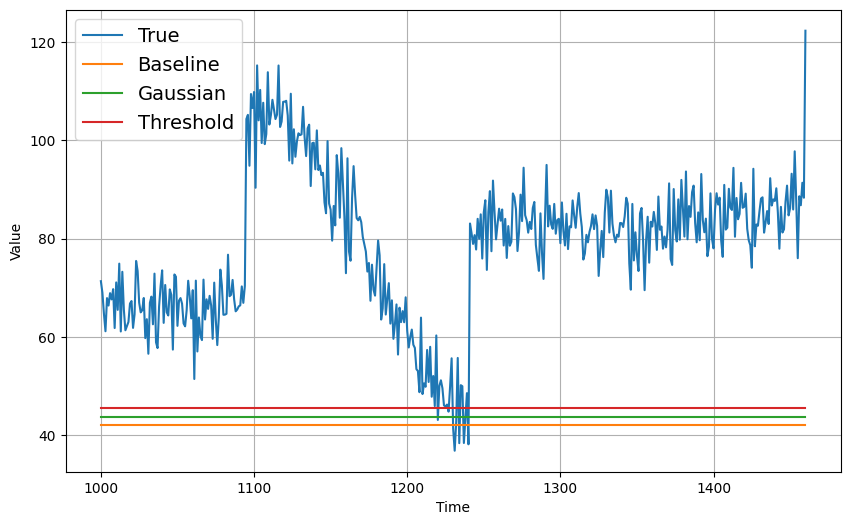

In [56]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, dense_forecast, label = "Baseline")
plot_series(time_valid, gaussian_dense_forecast, label = "Gaussian")
plot_series(time_valid, threshold_dense_forecast, label = "Threshold")

In [ ]:
print(keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy())

print(keras.metrics.mean_absolute_error(x_valid, gaussian_dense_forecast).numpy())

36.857216
35.978462
